# Прогнозирование недельных продаж Walmart

В этом ноутбуке:
1. Формулирую задачу с точки зрения бизнеса.
2. Загружаю и привожу данные к удобному виду.
3. Делаю первичный исследовательский анализ (EDA) по продажам и факторам.

Датасет: недельные продажи магазинов Walmart с макроэкономическими и календарными признаками.

## 1. Бизнес-постановка

**Проблема:**  
ошибки в прогнозах спроса приводят к:
- лишним запасам и заморозке денег на складе;
- дефициту товара и недовольным покупателям.

**Что я хочу сделать:**
- построить прогноз недельных продаж по магазинам;
- посмотреть, как на спрос влияют:
  - праздничные недели (`Holiday_Flag`);
  - макроэкономика (`CPI`, `Unemployment`);
  - цена топлива (`Fuel_Price`);
  - температура (`Temperature`).

**Дальнейшие шаги (в других ноутбуках):**
- собрать несколько моделей (ARIMA/Prophet/ML);
- сравнить их по метрикам (WAPE, MAPE и т.п.);
- сформулировать бизнес-выводы.


## 2. EDA
### Импорты и базовые настройки

Здесь собираю весь минимальный набор библиотек, который понадобится в EDA: pandas, matplotlib, seaborn.  
Сразу настраиваю стиль графиков и отображение таблиц, чтобы всё выглядело аккуратно.


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["axes.titlesize"] = 14
plt.rcParams["axes.labelsize"] = 12

pd.set_option("display.max_rows", 50)
pd.set_option("display.max_columns", None)
pd.set_option("display.float_format", "{:,.2f}".format)

### Загрузка датасета

На этом этапе просто проверяю, что данные корректно читаются и примерно понимаю их размер.


In [33]:
df = pd.read_csv('Walmart_Sales.csv')

print("Размер датасета:", df.shape)
df.head()


Размер датасета: (6435, 8)


,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,"1,643,690.90",0,42.31,2.57,211.10,8.11
1,1,12-02-2010,"1,641,957.44",1,38.51,2.55,211.24,8.11
2,1,19-02-2010,"1,611,968.17",0,39.93,2.51,211.29,8.11
3,1,26-02-2010,"1,409,727.59",0,46.63,2.56,211.32,8.11
4,1,05-03-2010,"1,554,806.68",0,46.50,2.62,211.35,8.11


### Быстрый взгляд на структуру таблицы

Хочу посмотреть, какие типы данных у столбцов, есть ли даты строками, нет ли странных типов вроде “object” там, где должны быть числа.  
Это помогает заранее увидеть потенциальные проблемы.


In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Date          6435 non-null   object 
 2   Weekly_Sales  6435 non-null   float64
 3   Holiday_Flag  6435 non-null   int64  
 4   Temperature   6435 non-null   float64
 5   Fuel_Price    6435 non-null   float64
 6   CPI           6435 non-null   float64
 7   Unemployment  6435 non-null   float64
dtypes: float64(5), int64(2), object(1)
memory usage: 402.3+ KB


### Приведение дат к datetime и сортировка

Дата в таблице хранится строкой, поэтому сначала превращаю её в нормальный datetime.  
Потом сортирую по магазину и дате.


In [35]:
df["Date"] = pd.to_datetime(df["Date"], format="%d-%m-%Y")

# Сортируем по магазину и дате
df = df.sort_values(["Store", "Date"]).reset_index(drop=True)

df[["Store", "Date", "Weekly_Sales"]].head()


,Store,Date,Weekly_Sales
0,1,2010-02-05,"1,643,690.90"
1,1,2010-02-12,"1,641,957.44"
2,1,2010-02-19,"1,611,968.17"
3,1,2010-02-26,"1,409,727.59"
4,1,2010-03-05,"1,554,806.68"


### Добавляю базовые календарные признаки

Эти поля потом пригодятся и для анализа сезонности, и для моделей.


In [36]:

df["Year"] = df["Date"].dt.year
df["Month"] = df["Date"].dt.month
df["WeekOfYear"] = df["Date"].dt.isocalendar().week.astype(int)

df["IsHoliday"] = df["Holiday_Flag"] == 1

df.head()


,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Year,Month,WeekOfYear,IsHoliday
0,1,2010-02-05,"1,643,690.90",0,42.31,2.57,211.10,8.11,2010,2,5,False
1,1,2010-02-12,"1,641,957.44",1,38.51,2.55,211.24,8.11,2010,2,6,True
2,1,2010-02-19,"1,611,968.17",0,39.93,2.51,211.29,8.11,2010,2,7,False
3,1,2010-02-26,"1,409,727.59",0,46.63,2.56,211.32,8.11,2010,2,8,False
4,1,2010-03-05,"1,554,806.68",0,46.50,2.62,211.35,8.11,2010,3,9,False


### Проверка пропусков и дубликатов

Смотрю, есть ли пустые значения или повторяющиеся строки.  



In [37]:
nulls = df.isna().sum()
print("Пропуски по столбцам:")
print(nulls)

dups = df.duplicated().sum()
print("\nКоличество полных дубликатов строк:", dups)


Пропуски по столбцам:
Store           0
Date            0
Weekly_Sales    0
Holiday_Flag    0
Temperature     0
Fuel_Price      0
CPI             0
Unemployment    0
Year            0
Month           0
WeekOfYear      0
IsHoliday       0
dtype: int64

Количество полных дубликатов строк: 0


### Быстрая статистика по числовым колонкам

Смотрю средние значения, минимумы, максимумы — в каком вообще масштабе живут данные.  
Это помогает понять, какие признаки могут быть чувствительными, а какие нужно будет нормализовать.

In [38]:
df.describe().T

,count,mean,min,25%,50%,75%,max,std
Store,"6,435.00",23.00,1.00,12.00,23.00,34.00,45.00,12.99
Date,6435,2011-06-17 00:00:00,2010-02-05 00:00:00,2010-10-08 00:00:00,2011-06-17 00:00:00,2012-02-24 00:00:00,2012-10-26 00:00:00,NaN
Weekly_Sales,"6,435.00","1,046,964.88","209,986.25","553,350.10","960,746.04","1,420,158.66","3,818,686.45","564,366.62"
Holiday_Flag,"6,435.00",0.07,0.00,0.00,0.00,0.00,1.00,0.26
Temperature,"6,435.00",60.66,-2.06,47.46,62.67,74.94,100.14,18.44
Fuel_Price,"6,435.00",3.36,2.47,2.93,3.44,3.73,4.47,0.46
CPI,"6,435.00",171.58,126.06,131.74,182.62,212.74,227.23,39.36
Unemployment,"6,435.00",8.00,3.88,6.89,7.87,8.62,14.31,1.88
Year,"6,435.00","2,010.97","2,010.00","2,010.00","2,011.00","2,012.00","2,012.00",0.80
Month,"6,435.00",6.45,1.00,4.00,6.00,9.00,12.00,3.24


### Сколько у нас вообще магазинов

Хочу понять, насколько данные сбалансированы по магазинам: у всех ли одинаковое количество наблюдений, нет ли точек, где мало данных.  
Это пригодится, когда дойдём до моделей.


In [39]:
n_stores = df["Store"].nunique()
print("Количество магазинов:", n_stores)

store_counts = (
    df.groupby("Store")["Weekly_Sales"]
    .count()
    .rename("n_weeks")
    .reset_index()
    .sort_values("n_weeks", ascending=False)
)

store_counts.head(10)


Количество магазинов: 45


,Store,n_weeks
0,1,143
23,24,143
25,26,143
26,27,143
27,28,143
28,29,143
29,30,143
30,31,143
31,32,143
32,33,143


### Распределение Weekly_Sales

Смотрю, какое распределение у продаж.  
Часто продажи имеют вытянутый хвост — логарифм помогает это выровнять.  
Здесь проверяю, насколько это актуально для Walmart.


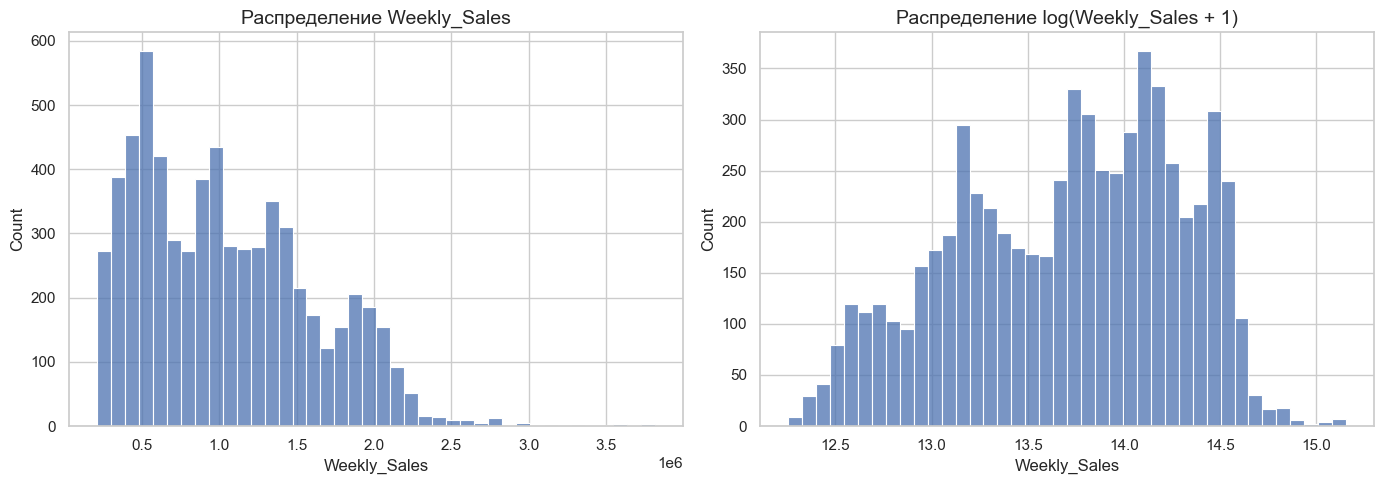

In [40]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.histplot(df["Weekly_Sales"], bins=40, ax=axes[0])
axes[0].set_title("Распределение Weekly_Sales")

sns.histplot(np.log1p(df["Weekly_Sales"]), bins=40, ax=axes[1])
axes[1].set_title("Распределение log(Weekly_Sales + 1)")

plt.tight_layout()
plt.show()

### Общий тренд по всей сети

Для начала смотрю агрегированные продажи по всем магазинам.  
Это даёт понимание: есть ли тренд, когда пики, сколько сезонности, есть ли провалы по датам.


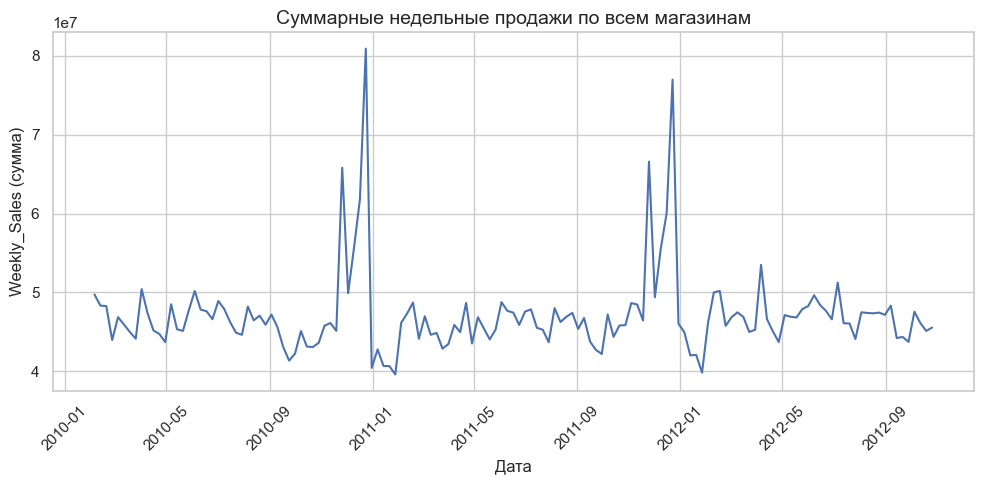

,Date,Weekly_Sales
0,2010-02-05,"49,750,740.50"
1,2010-02-12,"48,336,677.63"
2,2010-02-19,"48,276,993.78"
3,2010-02-26,"43,968,571.13"
4,2010-03-05,"46,871,470.30"


In [41]:
agg_weekly = (
    df.groupby("Date")["Weekly_Sales"]
    .sum()
    .reset_index()
    .sort_values("Date")
)

fig, ax = plt.subplots()
ax.plot(agg_weekly["Date"], agg_weekly["Weekly_Sales"])
ax.set_title("Суммарные недельные продажи по всем магазинам")
ax.set_xlabel("Дата")
ax.set_ylabel("Weekly_Sales (сумма)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

agg_weekly.head()


### Поведение разных магазинов

Важно понять, как магазины ведут себя.  
Если один магазин растёт и другой тоже — это влияет на то, как строить модель: глобальную или индивидуальную.  
Вывожу несколько для примера.


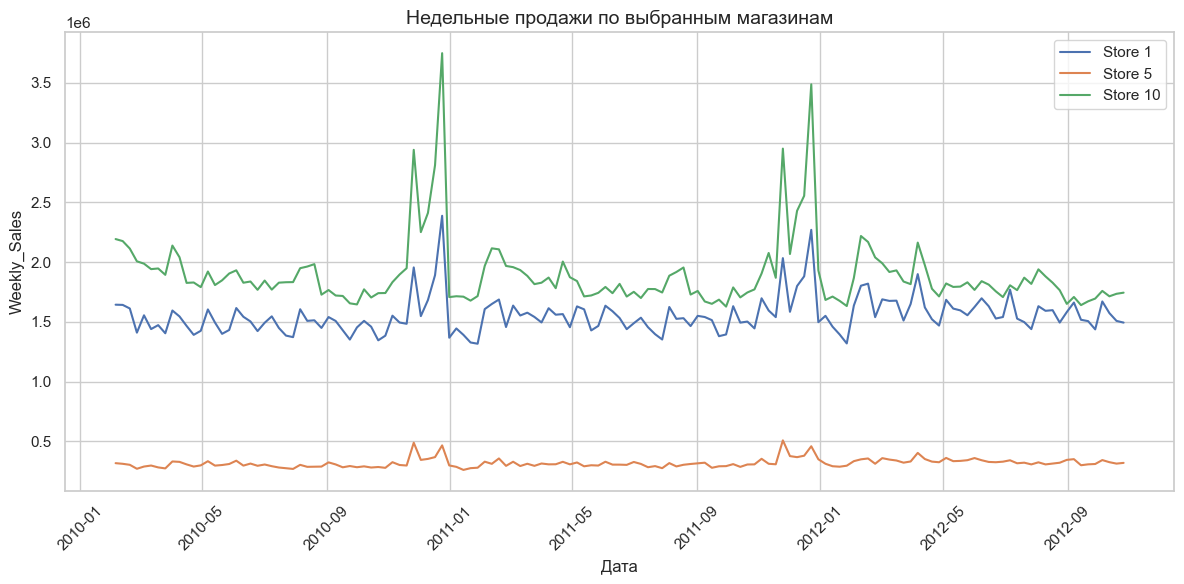

In [50]:

sample_stores = [1, 5, 10]
df_sample = df[df["Store"].isin(sample_stores)]

fig, ax = plt.subplots(figsize=(12, 6))

for store_id, part in df_sample.groupby("Store"):
    ax.plot(part["Date"], part["Weekly_Sales"], label=f"Store {store_id}")

ax.set_title("Недельные продажи по выбранным магазинам")
ax.set_xlabel("Дата")
ax.set_ylabel("Weekly_Sales")
plt.xticks(rotation=45)
ax.legend()
plt.tight_layout()
plt.show()


### Средние продажи по месяцам

Пробую понять, есть ли выраженные сезонные паттерны: может, летом продажи падают, а перед Новым годом растут.  
Среднее по месяцам — простое и наглядное начало.


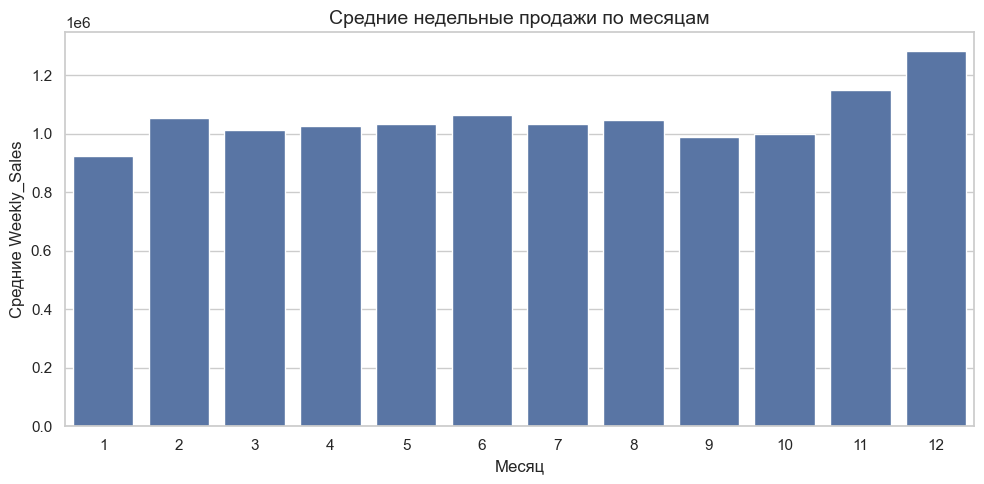

,Month,Weekly_Sales
0,1,"923,884.55"
1,2,"1,053,199.80"
2,3,"1,013,309.23"
3,4,"1,026,761.56"
4,5,"1,031,714.02"
5,6,"1,064,324.59"
6,7,"1,031,747.58"
7,8,"1,048,017.45"
8,9,"989,335.35"
9,10,"999,632.12"


In [43]:
monthly_avg = (
    df.groupby("Month")["Weekly_Sales"]
    .mean()
    .reset_index()
    .sort_values("Month")
)

fig, ax = plt.subplots()
sns.barplot(data=monthly_avg, x="Month", y="Weekly_Sales", ax=ax)
ax.set_title("Средние недельные продажи по месяцам")
ax.set_xlabel("Месяц")
ax.set_ylabel("Средние Weekly_Sales")
plt.tight_layout()
plt.show()

monthly_avg


### Средние продажи по неделям года

Похожая идея, только вместо месяцев использую недели.  
Это помогает заметить мелкие сезонные всплески.


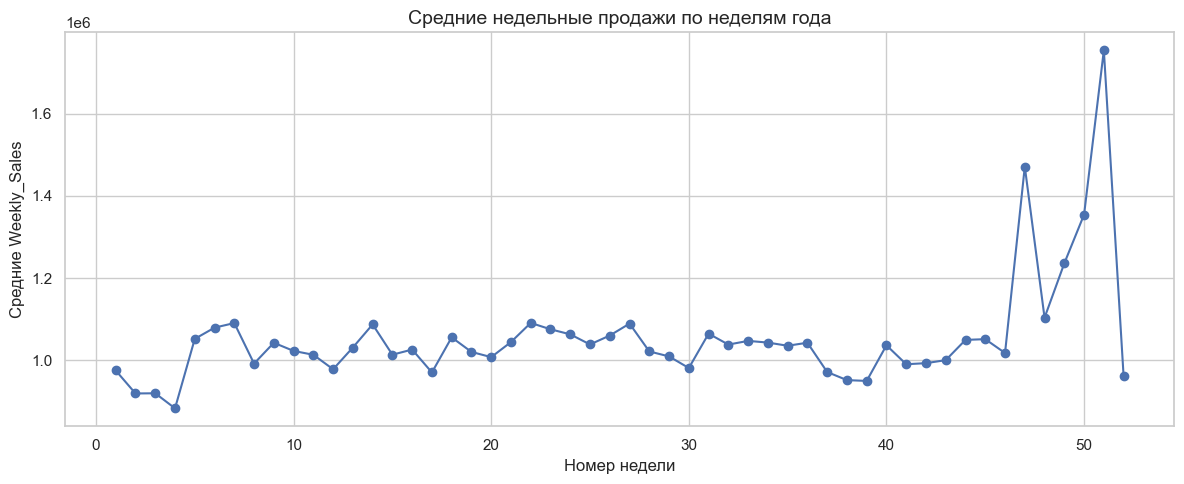

,WeekOfYear,Weekly_Sales
0,1,"974,791.22"
1,2,"918,852.85"
2,3,"919,284.94"
3,4,"882,609.20"
4,5,"1,051,773.78"


In [44]:
week_avg = (
    df.groupby("WeekOfYear")["Weekly_Sales"]
    .mean()
    .reset_index()
    .sort_values("WeekOfYear")
)

fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(week_avg["WeekOfYear"], week_avg["Weekly_Sales"], marker="o")
ax.set_title("Средние недельные продажи по неделям года")
ax.set_xlabel("Номер недели")
ax.set_ylabel("Средние Weekly_Sales")
plt.tight_layout()
plt.show()

week_avg.head()


### Влияние праздников

Проверяю, действительно ли праздничные недели отличаются по уровню продаж.  
Boxplot позволяет наглядно увидеть это.


                    mean       median  count
IsHoliday                                   
Not holiday 1,041,256.38   956,211.20   5985
Holiday     1,122,887.89 1,018,538.04    450


C:\Users\nikita\AppData\Local\Temp\ipykernel_988\27413531.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["Not holiday", "Holiday"])


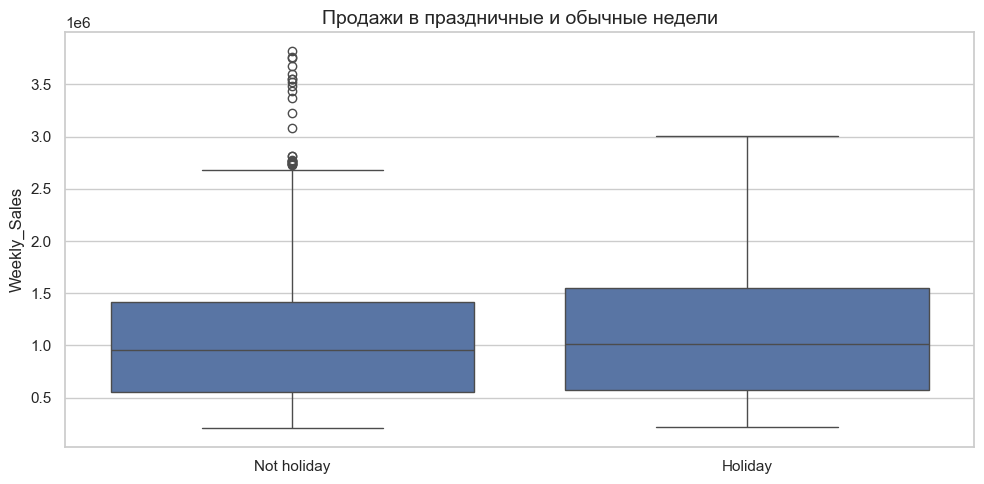

In [45]:
holiday_stats = (
    df.groupby("IsHoliday")["Weekly_Sales"]
    .agg(["mean", "median", "count"])
    .rename(index={False: "Not holiday", True: "Holiday"})
)

print(holiday_stats)

fig, ax = plt.subplots()
sns.boxplot(data=df, x="IsHoliday", y="Weekly_Sales", ax=ax)
ax.set_xticklabels(["Not holiday", "Holiday"])
ax.set_title("Продажи в праздничные и обычные недели")
ax.set_xlabel("")
ax.set_ylabel("Weekly_Sales")
plt.tight_layout()
plt.show()


### Корреляции с внешними признаками

Смотрю, насколько продажи связаны с CPI, безработицей, ценой топлива и температурой.  


In [46]:
num_cols = ["Weekly_Sales", "Temperature", "Fuel_Price", "CPI", "Unemployment"]
corr = df[num_cols].corr()

corr


,Weekly_Sales,Temperature,Fuel_Price,CPI,Unemployment
Weekly_Sales,1.00,-0.06,0.01,-0.07,-0.11
Temperature,-0.06,1.00,0.14,0.18,0.10
Fuel_Price,0.01,0.14,1.00,-0.17,-0.03
CPI,-0.07,0.18,-0.17,1.00,-0.30
Unemployment,-0.11,0.10,-0.03,-0.30,1.00


### Heatmap

Строю тепловую карту корреляций, чтобы увидеть, где сильные связи.  
После этого станет понятно, какие признаки стоит включать в модели.


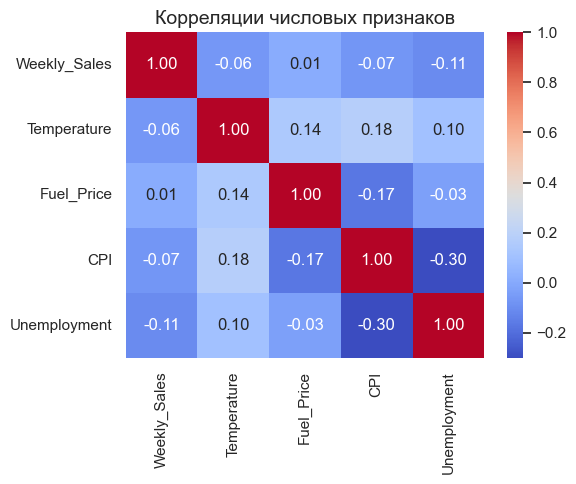

In [47]:
fig, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", ax=ax)
ax.set_title("Корреляции числовых признаков")
plt.tight_layout()
plt.show()


## 3. Инсайты

### 1. Количество магазинов и число недель

- В датасете 45 магазинов.
- У каждого магазина одинаковое количество наблюдений: 143 недели.
- Распределение равномерное, пропусков по магазинам нет.

Вывод: данные синхронные, можно строить как индивидуальные модели, так и одну общую.

### 2. Распределение Weekly_Sales
- Продажи распределены ненормально, наблюдается сильная асимметрия вправо.
- После логарифмирования распределение становится более нормальным.

Вывод: логарифмирование целевой переменной может улучшить стабильность моделей.

### 3. Суммарные недельные продажи по сети
- Временной ряд содержит стабильные значения в течение года.
- Ежегодно присутствуют выраженные пики в конце года и последующие снижения в январе.

Вывод: ярко выражена годовая сезонность. Пиковые значения необходимо учитывать в модели.

### 4. Суммарные недельные продажи по сети
- Магазины различаются по масштабам продаж.
- У разных магазинов различается уровень колебаний.

Вывод: данные неоднородны. Перед использованием глобальных моделей возможно потребуется нормализация или масштабирование.

### 5. Средние продажи по месяцам
- Январь и сентябрь имеют минимальные средние значения.
- Декабрь имеет максимальные значения.

Вывод: присутствует стабильная сезонность по месяцам.

### 6. Средние продажи по неделям года
- Основная часть года имеет близкие значения средней выручки.
- Резкие увеличения наблюдаются в последних неделях года.

Вывод: недельная сезонность также выражена, особенно в конце года.

### 7. Продажи в праздничные и обычные недели
- Медианные продажи в праздничные недели выше, чем в обычные.
- Размах значений у праздничных недель больше.

Вывод: праздничные недели являются значимым фактором и должны быть включены в модель как отдельная переменная.

### 8. Корреляции с макроэкономическими факторами
- Связь между Weekly_Sales и макропоказателями слабая.
- CPI и Unemployment имеют умеренную отрицательную связь.
- Fuel_Price и Temperature показывают минимальные зависимости.

Вывод: макропоказатели можно использовать как дополнительные признаки, но ожидать сильного влияния не стоит.

## 4. Итоги исследования данных
На текущем этапе сформировано базовое представление о структуре датасета и динамике продаж:
- присутствуют выраженные сезонные колебания и повторяющиеся годовые пики;
- между магазинами наблюдаются различия в масштабах продаж;
- распределение Weekly_Sales имеет значительную асимметрию;
- праздничные недели оказывают заметное влияние на уровень продаж;
- макроэкономические переменные демонстрируют слабые, но стабильные зависимости и могут быть использованы как дополнительные факторы.